Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Truncate: 1228
Importance weights loaded successfully.


Epoch 50/50: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, loss=0.00519]


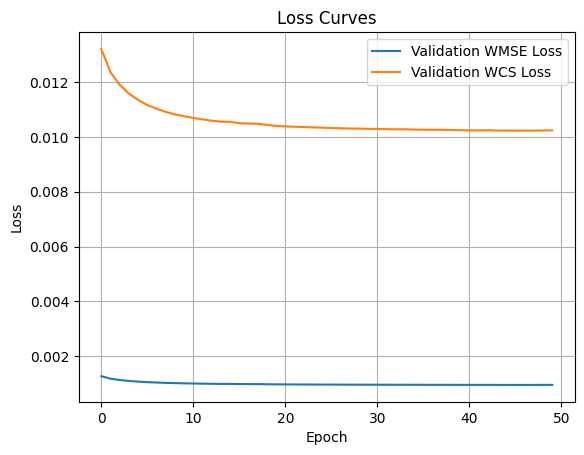

In [1]:
import torch
from tqdm import tqdm
from modules import HybridLoss
import torch.nn.functional as F
import torch.nn as nn

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads_out.pt"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]

U, S, VT = torch.linalg.svd(W, full_matrices=False)
s_sqrt = torch.diag(torch.sqrt(S))
u_parameter = torch.matmul(U[:, :truncate], s_sqrt[:truncate, :truncate])
vt_parameter = torch.matmul(s_sqrt[:truncate, :truncate], VT[:truncate, :])

svd_layer = nn.Sequential(
    nn.Linear(
        in_features=vt_parameter.shape[1],
        out_features=vt_parameter.shape[0],
        bias=False,
        device=DEVICE
    ),
    nn.Linear(
        in_features=u_parameter.shape[1],
        out_features=u_parameter.shape[0],
        bias=False,
        device=DEVICE
    )
).to(DEVICE).train()

svd_layer[0].weight.data = vt_parameter.float()
svd_layer[1].weight.data = u_parameter.float()

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

# Load importance weights if available
try:
    with open(IMPORTANCE_PATH, "rb") as f:
        grads_dict = torch.load(f)
        importance_weights = grads_dict[LAYER_HOOK] if LAYER_HOOK in grads_dict else None

    if importance_weights is not None:
        importance_weights = torch.where(importance_weights < 0.01, torch.tensor(0.01, device=importance_weights.device), importance_weights)
    print("Importance weights loaded successfully.")
except FileNotFoundError:
    importance_weights = None
    print("Importance weights file not found. Proceeding without importance weights.")

loss_fn = HybridLoss(weights=importance_weights,
                        alpha=0.5,  # Adjust alpha as needed
                        reduction="mean",
                        return_separate=True).to(DEVICE)

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_wmse_loss_log = []
train_wcs_loss_log = []
val_wmse_loss_log = []
val_wcs_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    wmse_epoch_loss_log = []
    wcs_epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Shuffle the training data at the start of each epoch
    pre_act_train = pre_act_train[torch.randperm(pre_act_train.size(0))]
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        wmse_loss, wcs_loss, total_loss = loss_fn(output, og_linear_module(batch))
        total_loss.backward()

        # Update weights
        optimizer.step()
        wmse_epoch_loss_log.append(wmse_loss.item())
        wcs_epoch_loss_log.append(wcs_loss.item())
        pbar.set_postfix({"loss": total_loss.item()})
    avg_wmse_loss = sum(wmse_epoch_loss_log) / len(wmse_epoch_loss_log)
    avg_wcs_loss = sum(wcs_epoch_loss_log) / len(wcs_epoch_loss_log)

    svd_layer.eval()
    with torch.no_grad():
        wmse_val_loss, wcs_val_loss, val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
    train_wmse_loss_log.append(avg_wmse_loss)
    train_wcs_loss_log.append(avg_wcs_loss)
    val_wmse_loss_log.append(wmse_val_loss.item())
    val_wcs_loss_log.append(wcs_val_loss.item())
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(val_wmse_loss_log, label='Validation WMSE Loss')
plt.plot(val_wcs_loss_log, label='Validation WCS Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

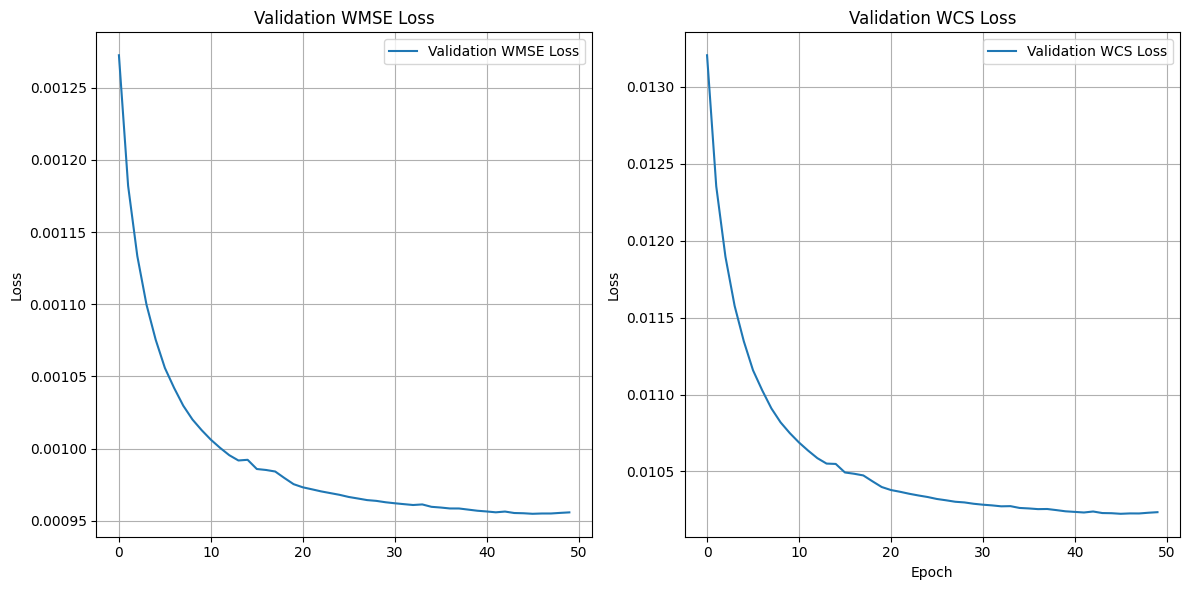

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, shared x-axis

ax1.plot(val_wmse_loss_log, label='Validation WMSE Loss')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation WMSE Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(val_wcs_loss_log, label='Validation WCS Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation WCS Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [7]:
import torch

with torch.no_grad():
    Y = og_linear_module(pre_act_val.to(DEVICE))
    Y_hat = svd_layer(pre_act_val.to(DEVICE))

# Move to CPU for calculations
Y_cpu = Y.cpu()
Y_hat_cpu = Y_hat.cpu()

mean_Y = torch.mean(Y_cpu).item()
var_Y = torch.var(Y_cpu).item()

mean_Y_hat = torch.mean(Y_hat_cpu).item()
var_Y_hat = torch.var(Y_hat_cpu).item()

# Flatten batch and seq dimensions for cosine similarity
Y_flat = Y_cpu.view(-1, Y_cpu.shape[-1])
Y_hat_flat = Y_hat_cpu.view(-1, Y_hat_cpu.shape[-1])

cos_sim = torch.nn.functional.cosine_similarity(Y_flat, Y_hat_flat, dim=1)
avg_cos_sim = torch.mean(cos_sim).item()

print(f"Original Layer Mean: {mean_Y}, Variance: {var_Y}")
print(f"Compressed Layer Mean: {mean_Y_hat}, Variance: {var_Y_hat}")
print(f"Average Cosine Similarity: {avg_cos_sim}")

Original Layer Mean: 0.02182718552649021, Variance: 1.3039408922195435
Compressed Layer Mean: 0.02170608565211296, Variance: 1.2768893241882324
Average Cosine Similarity: 0.9278676509857178
